In [59]:
%load_ext autoreload
%autoreload 2

import os
import sys
import glob
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
import seaborn as sns
import tqdm
import npyx
from npyx.gl import get_units
from npyx.spk_t import trn
from npyx.corr import ccg
import pandas as pd
from collections import defaultdict

from utils import figutils
from utils import styleutils

sns.reset_defaults()
styleutils.update_mpl_params(fontsize=7, linewidth=1)
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


E:\NPIX\NPIX1\2023.10.09\catgt_s4_g0\s4_g0_imec0\imec0_ks2
N good cells: 227, N total cells: 294
N SS clusters: 22, N CS clusters: 132


100%|██████████| 22/22 [00:00<00:00, 21991.11it/s]


N pairs to compute: 209


100%|██████████| 22/22 [00:45<00:00,  2.05s/it]


defaultdict(<class 'list'>, {67: [[70, 0.45454545454545453]], 75: [[70, 0.3739612188365651]], 115: [[121, 0.04303973567515868], [127, 0.22388059701492538], [130, 0.12195121951219512]], 184: [[152, 0.2807775377969762], [153, 0.23379383634431453], [161, 0.2563871896365599], [165, 0.26340110905730135], [182, 0.20737327188940094], [183, 0.26590198123044834]], 186: [[160, 0.05926251097453908], [162, 0.07418576598311219]], 187: [[182, 0.07594936708860762]], 236: [[245, 0.3620035862312237]]})


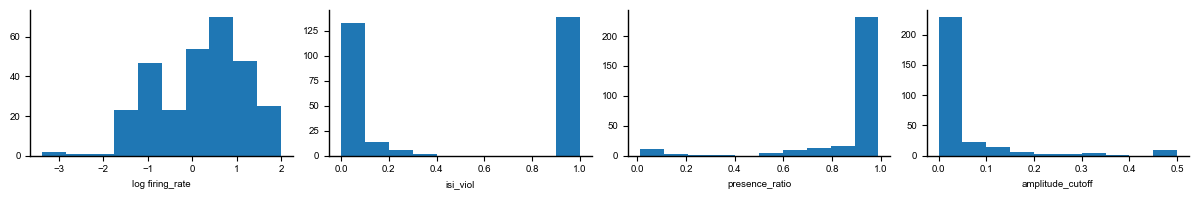

In [67]:
dps = [
    # r'D:\NPIX\NPIX1\2023.08.23\catgt_pw1_20230823_shank3_bot_g0\pw1_20230823_shank3_bot_g0_imec0\imec0_ks2',
    # r'D:\NPIX\NPIX1\2023.08.23\catgt_pw1_20230823_shank2_bot_g0\pw1_20230823_shank2_bot_g0_imec0\imec0_ks2',
    # r'D:\NPIX\NPIX1\2023.08.23\catgt_pw1_20230823_shank1_bot_g0\pw1_20230823_shank1_bot_g0_imec0\imec0_ks2',
    # r'E:\NPIX\NPIX1\2023.08.23\catgt_pw1_20230823_shank4_bot_g1_ks2\pw1_20230823_shank4_bot_g1_imec0\imec0_ks2',
    # r'E:\NPIX\NPIX1\2023.08.23\catgt_pw1_20230823_shank4_bot_g1_ks25\pw1_20230823_shank4_bot_g1_imec0\imec0_ks2',
    # r'E:\NPIX\NPIX1\2023.08.23\catgt_pw1_20230823_shank4_bot_g1_ks3\pw1_20230823_shank4_bot_g1_imec0\imec0_ks2',
    # r'E:\NPIX\NPIX1\2023.09.13\catgt_npx1_shank4_20230913_g0\npx1_shank4_20230913_g0_imec0\imec0_ks2',
    # r'E:\NPIX\NPIX1\2023.09.14\catgt_npx1_shank4_20230914_g0\npx1_shank4_20230914_g0_imec0\imec0_ks2',
    # r'E:\NPIX\NPIX1\2023.09.15\catgt_npx1_shank3_g0\npx1_shank3_g0_imec0\imec0_ks2',
    # r'E:\NPIX\NPIX1\2023.09.15\catgt_npx1_shank2_g0\npx1_shank2_g0_imec0\imec0_ks2',
    # r'E:\NPIX\NPIX1\2023.09.15\catgt_npx1_shank1_g0\npx1_shank1_g0_imec0\imec0_ks2',
    # r'E:\NPIX\NPIX1\2023.10.08\catgt_2023_10_08_shank4_g0\2023_10_08_shank4_g0_imec0\imec0_ks2',
    r'E:\NPIX\NPIX1\2023.10.09\catgt_s4_g0\s4_g0_imec0\imec0_ks2'
]

for dp in dps:
    print(dp)
    metrics = pd.read_csv(os.path.join(dp, 'metrics.csv'))
    metrics.head()

    # (KW, logx, logy)
    to_plot = [
        ('firing_rate', True, False),
        ('isi_viol', False, False),
        ('presence_ratio', False, False),
        ('amplitude_cutoff', False, False),
    ]

    f, axs = figutils.pretty_fig(figsize=(3 * len(to_plot), 2), rows=1, cols=len(to_plot))
    for i, tup in enumerate(to_plot):
        plt.sca(axs[i])
        metric = tup[0]
        logx = tup[1]
        logy = tup[2]

        data = metrics[metric]
        if logx:
            data = np.log10(data + 0.00001)
        plt.hist(data, log=logy)
        sns.despine()
        if logx:
            xlabel = 'log ' + metric
        else:
            xlabel = metric
        plt.xlabel(xlabel)
    plt.tight_layout()


    criteria = np.array([
        metrics['firing_rate'] > 0.01,
        # metrics['isi_viol'] < 0.5,
        # metrics['presence_ratio'] > 0.7,
        metrics['amplitude_cutoff'] < 0.05,
    ])

    good_mask = np.all(criteria, axis=0)
    metrics['QC'] = good_mask
    metrics.to_csv(os.path.join(dp, 'metrics.csv'), index=False)
    print(f'N good cells: {good_mask.sum()}, N total cells: {len(good_mask)}')

    meta = npyx.read_metadata(dp)
    recording_s = meta['recording_length_seconds']
    samp_rate = meta['highpass']['sampling_rate']

    chan_map = np.array(np.load(os.path.join(dp, 'channel_map.npy'))).flatten()
    chan_pos = np.load(os.path.join(dp, 'channel_positions.npy'))
    pos_x = chan_pos[:, 0]
    pos_y = chan_pos[:, 1]
    # assert np.array_equal(chan_map, np.arange(len(chan_map)))

    depths = []
    for chan in metrics['peak_channel']:
        ix = np.argwhere(chan == chan_map)[0][0]
        depths.append(pos_y[ix])
    depths = np.array(depths)

    metrics['depth'] = depths
    cluster_ids = metrics['cluster_id'].to_numpy()

    # calculate probe adjacency matrix
    adjacency_threshold = 80 #um
    adjacencies = {}
    for id, depth in zip(cluster_ids, depths):
        within_reach = np.logical_and(depth + adjacency_threshold > depths, depth - adjacency_threshold < depths)
        adjacencies[id] = cluster_ids[within_reach]

    # putative SS clusters
    criteria = np.array([
        metrics['firing_rate'].to_numpy() > 30,
        metrics['QC']
    ])
    good_mask = np.all(criteria, axis=0)
    ss_cluster_ids = cluster_ids[good_mask]

    # putative CS clusters
    criteria = np.array([
        metrics['firing_rate'].to_numpy() < 5,
        metrics['QC']
    ])
    good_mask = np.all(criteria, axis=0)
    cs_cluster_ids = cluster_ids[good_mask]

    print(f'N SS clusters: {len(ss_cluster_ids)}, N CS clusters: {len(cs_cluster_ids)}')

    bin_size = 1
    win_size = 80

    sum = 0
    cc_dict = {}
    for ss in tqdm.tqdm(ss_cluster_ids):
        valid_cs = np.intersect1d(adjacencies[ss], cs_cluster_ids)
        cc_dict[ss] = list(valid_cs)
        sum += len(valid_cs)
    print(f'N pairs to compute: {sum}')

    from scipy.signal import savgol_filter
    win_size = 80
    bin_size = 1

    pairs = defaultdict(list)
    for ss, css in tqdm.tqdm(cc_dict.items()):
        for cs in css:
            # try:
            c = ccg(dp, [cs, ss], bin_size=bin_size, win_size=win_size, normalize='Hertz')
            cc = c[0, 1]
            cc = savgol_filter(cc, window_length=3, polyorder=0)
            middle = int(1+win_size/2)
            s = 5
            e = 20
            metric = np.min(cc[middle+s:middle+e]) / np.mean(cc[middle-e:middle-s])
            if metric < 0.5:
                pairs[ss].append([cs, metric])
            # except:
            #     print(cs, ss)
    print(pairs)


In [65]:
pairs

defaultdict(list,
            {67: [[70, 0.45454545454545453]],
             75: [[70, 0.3739612188365651]],
             115: [[121, 0.04303973567515868],
              [127, 0.22388059701492538],
              [130, 0.12195121951219512]],
             184: [[152, 0.2807775377969762],
              [153, 0.23379383634431453],
              [161, 0.2563871896365599],
              [165, 0.26340110905730135],
              [182, 0.20737327188940094],
              [183, 0.26590198123044834]],
             186: [[160, 0.05926251097453908], [162, 0.07418576598311219]],
             187: [[182, 0.07594936708860762]],
             236: [[245, 0.3620035862312237]]})

Text(0.5, 1.0, '0.004689698296076286')

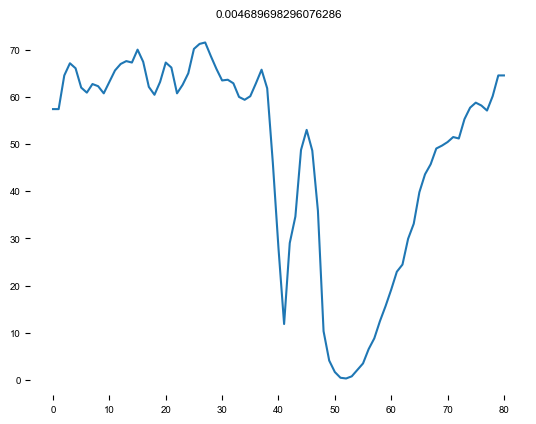

In [56]:
ss = 36
cs = 37

c = ccg(dp, [cs, ss], bin_size=bin_size, win_size=win_size, normalize='Hertz')
if ss != cs:
    cc = c[0, 1]
else:
    cc = c.flatten()
cc = savgol_filter(cc, window_length=3, polyorder=0)
middle = int(1+win_size/2)
s = 5
e = 20
metric = np.min(cc[middle+s:middle+e]) / np.mean(cc[middle-e:middle-s])
plt.plot(cc)
plt.title(metric)

In [ ]:
# calculate cv
dp = r'D:\NPIX\NPIX1\2023.08.23\catgt_pw1_20230823_shank4_bot_g1\pw1_20230823_shank4_bot_g1_imec0\imec0_ks2'
trn_dict = {}
for id in tqdm.tqdm(ss_cluster_ids):
    trn_dict[id] = npyx.trn(dp, id)
    isi_ms = np.diff(trn_dict[id]) / samp_rate * 1000
    m = np.mean(isi_ms)
    std = np.std(isi_ms)
    cv = std / m
    cv2 = np.square(cv)
    if cv2 < 0.2:
        print(id, cv2)

    isi_ms = np.diff(trn_dict[id]) / samp_rate * 1000
    median_isi = np.median(isi_ms)
    mad = np.median(isi_ms - median_isi)
    # print(id, mad)


0.21883289124668429


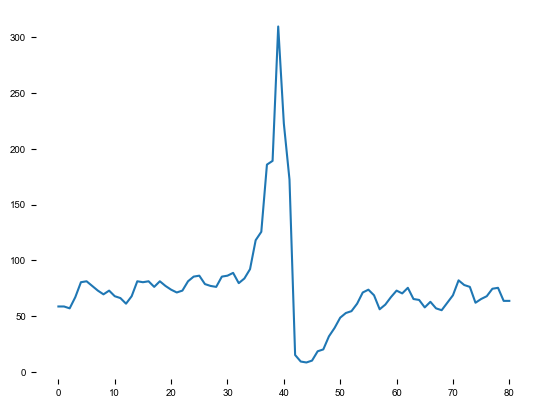

In [19]:
cs = 252
ss = 269
c = ccg(dp, [cs, ss], bin_size=bin_size, win_size=win_size, normalize='Hertz')
cc = c[0, 1]
cc = savgol_filter(cc, window_length=3, polyorder=0)
middle = int(1+win_size/2)
s = 5
e = 20
metric = np.min(cc[middle+s:middle+e]) / np.mean(cc[middle-e:middle-s])
plt.plot(cc)
print(metric)

In [ ]:
1/0

In [ ]:
# fig_path = os.path.join(dp, 'FIGURES')
# cols = 4
# for ss, css in tqdm.tqdm(cc_dict.items()):
#     n_cs = len(css)
#     if n_cs == 0:
#         continue
#
#     rows = np.ceil(n_cs / cols).astype(int)
#     f, axs = figutils.pretty_fig(
#         figsize=(12, rows*3),
#         rows=rows,
#         cols=cols,
#         sharex=True,
#         sharey=True,
#         rect=(0.25, 0.25, 0.6, 0.6))
#     for i, cs in enumerate(css):
#         if rows == 1:
#             plt.sca(axs[i])
#         else:
#             plt.sca(axs[i//cols, i%cols])
#
#         c = ccg(dp, [cs, ss], bin_size=bin_size, win_size=win_size, normalize='Hertz')
#         x = np.linspace(-win_size/2, win_size/2, int(win_size/bin_size)+1)
#
#         plt.plot(x, c[1, 1], label='SS(0)', color='k')
#
#         y = c[0, 1]
#         if np.max(y) < 300:
#             plt.plot(x, y, label='CS(0)', color='r')
#         plt.legend(loc='lower left')
#         plt.title(f'SS: {ss}, CS: {cs}')
#
#     if rows == 1:
#         plt.sca(axs[0])
#     else:
#         plt.sca(axs[0, 0])
#     plt.xticks([-win_size/2, -2, 2, win_size/2], [-win_size/2, '', '', win_size/2])
#     plt.tight_layout()
#     plt.xlabel('Time (ms)')
#     plt.ylabel('Firing rate (Hz)')
#     figutils.save_fig(fig_path, f'{ss}', pdf=False, show=False, close=True, verbose=False, transparent=False)

In [ ]:
# # my own code: doesn't work well if there are too many spikes
# unit_ids = get_units(dp, quality='all')
# spike_trains = []
# for u in tqdm.tqdm(unit_ids):
#     t = trn(dp, u)
#     spike_trains.append(t)


# bounds = 40 # in ms
# bounds_in_samps = int(bounds * samp_rate / 1000)
#
# tcs = trn(dp, 1).astype(int)
# tss = trn(dp, 86).astype(int)
#
# cs0 = []
# for cs in tcs:
#     temp = tss - cs
#     temp = temp[np.logical_and(temp<bounds_in_samps, temp>-bounds_in_samps)]
#     temp = temp[temp != 0]
#     cs0.append(temp)
# cs0_flattened = [x for y in cs0 for x in y]
# y, x = np.histogram(cs0_flattened, bins=bounds*2, range=[-bounds_in_samps, bounds_in_samps])
# x = x / (samp_rate / 1000) # convert to ms
# y = y * 1000 / len(tcs) # convert to hz
#
# plt.plot(x[:-1], y)
# plt.xlabel('Time (ms)')
# plt.ylabel('Firing rate (Hz)')
